# Modeling

## Import the Libraries

In [ ]:
# pip install optuna # Run this cell if Optuna is not installed in your pc

In [ ]:
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import xgboost as xgb
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## Import the Data

In [ ]:
sidf = pd.read_csv("https://raw.githubusercontent.com/DATS6103-Team5/FinalProject/main/data/simple_imputed_df.csv")
midf = pd.read_csv("https://raw.githubusercontent.com/DATS6103-Team5/FinalProject/main/data/model_imputed_df.csv")


display(sidf.head())
display(midf.head())

,id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,...,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,City,State,review_scores_rating,reviews_per_month,bathrooms
0,1489424,5294164,1.0,100.0,87.0,0,1,FOURTEENTH WARD,42.66719,-73.81580,...,248,50,6,0,1,albany,ny,4.75,1.94,1.0
1,2992450,4621559,3.0,100.0,100.0,0,0,THIRD WARD,42.65789,-73.75370,...,9,0,0,0,1,albany,ny,3.56,0.08,1.0
2,3820211,19648678,1.0,100.0,66.0,0,1,SIXTH WARD,42.65222,-73.76724,...,292,8,1,0,4,albany,ny,4.74,2.51,1.0
3,5651579,29288920,1.0,100.0,99.0,0,1,SECOND WARD,42.64615,-73.75966,...,337,31,4,0,2,albany,ny,4.51,3.13,1.0
4,6623339,19648678,1.0,100.0,66.0,0,1,SIXTH WARD,42.65222,-73.76724,...,306,5,0,0,4,albany,ny,4.73,2.87,1.0


,Unnamed: 0,id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,City,State,bathrooms
0,0,1489424,5294164,1.0,100.0,87.0,0,1,FOURTEENTH WARD,42.66719,...,4.92,4.92,4.82,4.81,0,1,1.94,albany,ny,1.0
1,1,2992450,4621559,3.0,100.0,100.0,0,0,THIRD WARD,42.65789,...,4.22,4.56,3.22,3.67,0,1,0.08,albany,ny,1.0
2,2,3820211,19648678,1.0,100.0,66.0,0,1,SIXTH WARD,42.65222,...,4.86,4.80,4.82,4.78,0,4,2.51,albany,ny,1.0
3,3,5651579,29288920,1.0,100.0,99.0,0,1,SECOND WARD,42.64615,...,4.82,4.87,4.79,4.64,0,2,3.13,albany,ny,1.0
4,4,6623339,19648678,1.0,100.0,66.0,0,1,SIXTH WARD,42.65222,...,4.83,4.68,4.81,4.72,0,4,2.87,albany,ny,1.0


In [ ]:
model_cols = ["host_response_rate", "host_acceptance_rate", "latitude", "longitude", "accommodates", "beds", "number_of_reviews", "number_of_reviews_ltm",
              "review_scores_rating", "reviews_per_month", "bathrooms", "price"]

model_sidf = sidf[model_cols]
model_sidf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253798 entries, 0 to 253797
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   host_response_rate     253798 non-null  float64
 1   host_acceptance_rate   253798 non-null  float64
 2   latitude               253798 non-null  float64
 3   longitude              253798 non-null  float64
 4   accommodates           253798 non-null  int64  
 5   beds                   253798 non-null  float64
 6   number_of_reviews      253798 non-null  int64  
 7   number_of_reviews_ltm  253798 non-null  int64  
 8   review_scores_rating   253798 non-null  float64
 9   reviews_per_month      253798 non-null  float64
 10  bathrooms              253798 non-null  float64
 11  price                  253798 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 23.2 MB


## Prepare the Data for Modeling

In [ ]:
X = model_sidf.drop(["price"], axis = 1)
y = model_sidf["price"]

X.shape, y.shape

((253798, 11), (253798,))

In [ ]:
# Split the data into train and test sets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((228418, 11), (25380, 11), (228418,), (25380,))

## Creating Baseline Models

### Linear Regression

In [ ]:
# Train the model using training set.

linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

lr_train_preds = linear_regressor.predict(X_train)

print(f"Mean Absolute Error for Training data: {mean_absolute_error(y_train, lr_train_preds)}")
print(f"Root Mean Squared Error for Training data: {mean_squared_error(y_train, lr_train_preds)**0.5}")

Mean Absolute Error for Training data: 96.98994406998814
Root Mean Squared Error for Training data: 150.98518074295237


In [ ]:
# Evaluating the linear model on the test set.

lr_test_preds = linear_regressor.predict(X_test)

print(f"Mean Absolute Error for Test data: {mean_absolute_error(y_test, lr_test_preds)}")
print(f"Root Mean Squared Error for Test_data: {mean_squared_error(y_test, lr_test_preds)**0.5}")

Mean Absolute Error for Test data: 96.52169943401785
Root Mean Squared Error for Test_data: 151.53116914903327


In [ ]:
# From the train and test results we can see that the model is underfitting. So let's increase the complexity of the models.

In [ ]:
# Creating a function to display the train and test metrics.

def display_results(model, y_train, train_preds, y_test, test_preds, exp):

  train_mae = mean_absolute_error(y_train, train_preds)
  train_rmse = mean_squared_error(y_train, train_preds)**0.5

  test_mae = mean_absolute_error(y_test, test_preds)
  test_rmse = mean_squared_error(y_test, test_preds)**0.5

  model_name = model.__class__.__name__

  print(f"Results for {model_name}:")
  print(f"Experiment: {exp}")
  print(f"Mean Absolute Error for Training data: {train_mae}")
  print(f"Root Mean Squared Error for Training data: {train_rmse}")

  print(f"Mean Absolute Error for Test data: {test_mae}")
  print(f"Root Mean Squared Error for Test data: {test_rmse}")

  return {"Model": model_name,
          "exp": exp,
          "Train MAE": train_mae,
          "Train RMSE": train_rmse,
          "Test MAE": test_mae,
          "Test RMSE": test_rmse}

In [ ]:
lr_results = display_results(linear_regressor, y_train, lr_train_preds, y_test, lr_test_preds, exp = "Linear Regression")

Results for LinearRegression:
Experiment: Linear Regression
Mean Absolute Error for Training data: 96.98994406998814
Root Mean Squared Error for Training data: 150.98518074295237
Mean Absolute Error for Test data: 96.52169943401785
Root Mean Squared Error for Test data: 151.53116914903327


### Decision Tree

In [ ]:
dtr_model = DecisionTreeRegressor()

dtr_model.fit(X_train, y_train)


dtr_train_preds = dtr_model.predict(X_train)

dtr_test_preds = dtr_model.predict(X_test)

dtr_results = display_results(dtr_model, y_train, dtr_train_preds, y_test, dtr_test_preds, exp = "Decision Tree Regression")

Results for DecisionTreeRegressor:
Experiment: Decision Tree Regression
Mean Absolute Error for Training data: 0.48209903668818554
Root Mean Squared Error for Training data: 7.0477477638819535
Mean Absolute Error for Test data: 85.6555038056964
Root Mean Squared Error for Test data: 153.93505031789545


In [ ]:
# The training results are great but the test results shows that the model actually overfitted. Let's see if we can regularize the model.

In [ ]:
dtr_model = DecisionTreeRegressor(max_depth = 15, min_samples_split = 40, min_samples_leaf = 10, min_impurity_decrease=0.0001)

dtr_model.fit(X_train, y_train)


dtr_train_preds = dtr_model.predict(X_train)

dtr_test_preds = dtr_model.predict(X_test)

dtr_results_tuned = display_results(dtr_model, y_train, dtr_train_preds, y_test, dtr_test_preds, exp = "Decision Tree Regression Tuned")

Results for DecisionTreeRegressor:
Experiment: Decision Tree Regression Tuned
Mean Absolute Error for Training data: 68.42185320434213
Root Mean Squared Error for Training data: 113.0055721144729
Mean Absolute Error for Test data: 75.924793221943
Root Mean Squared Error for Test data: 127.14320006889355


In [ ]:
# Looks like with a little bit of tuning (Just hand picked) the important parameters improved the model significantly. Restricting the model brought the balance between the training and
# test performance.

In [ ]:
# Let's see if we can keep on increasing the complexity of models and see how far we can go.

### Random Forest Regressor

In [ ]:
rfr_model = RandomForestRegressor()

rfr_model.fit(X_train, y_train)


rfr_train_preds = rfr_model.predict(X_train)

rfr_test_preds = rfr_model.predict(X_test)

rfr_results = display_results(rfr_model, y_train, rfr_train_preds, y_test, rfr_test_preds, exp = "Random Forest Regressor")

Results for RandomForestRegressor:
Experiment: Random Forest Regressor
Mean Absolute Error for Training data: 24.647378928645207
Root Mean Squared Error for Training data: 42.482636934083764
Mean Absolute Error for Test data: 65.18003500212772
Root Mean Squared Error for Test data: 111.52257671475253


In [ ]:
# Again we can see that the model is overfitting. So we need to tune the model parameters to balance the performance between the train and test.

In [ ]:
rfr_model = RandomForestRegressor(n_estimators=100, max_depth = 15, min_samples_split = 40, min_samples_leaf = 10)

rfr_model.fit(X_train, y_train)


rfr_train_preds = rfr_model.predict(X_train)

rfr_test_preds = rfr_model.predict(X_test)

rfr_results_tuned = display_results(rfr_model, y_train, rfr_train_preds, y_test, rfr_test_preds, exp = "Random Forest Regressor Tuned")

Results for RandomForestRegressor:
Experiment: Random Forest Regressor Tuned
Mean Absolute Error for Training data: 66.24769473296558
Root Mean Squared Error for Training data: 109.81034471587007
Mean Absolute Error for Test data: 71.55739350728994
Root Mean Squared Error for Test data: 119.44328496573816


### XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor()

xgb_model.fit(X_train, y_train)

xgb_train_preds = xgb_model.predict(X_train)

xgb_test_preds = xgb_model.predict(X_test)

xgb_results = display_results(xgb_model, y_train, xgb_train_preds, y_test, xgb_test_preds, exp = "XGBoost")

Results for XGBRegressor:
Experiment: XGBoost
Mean Absolute Error for Training data: 68.48331940377535
Root Mean Squared Error for Training data: 111.82330613427105
Mean Absolute Error for Test data: 70.94348557915295
Root Mean Squared Error for Test data: 117.32826736524217


In [ ]:
# It took a very few seconds for training XGB model compared to RandomForest model. And also the performance on test set (generalization) is better than the previous models.

### LightGBM

In [ ]:
lgbm_model = lgbm.LGBMRegressor(num_iterations = 1000)

lgbm_model.fit(X_train, y_train)

lgbm_train_preds = lgbm_model.predict(X_train)

lgbm_test_preds = lgbm_model.predict(X_test)

lgbm_results = display_results(lgbm_model, y_train, lgbm_train_preds, y_test, lgbm_test_preds, exp = "LightGBM")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 228418, number of used features: 11
[LightGBM] [Info] Start training from score 209.698605
Results for LGBMRegressor:
Experiment: LightGBM
Mean Absolute Error for Training data: 62.47449897109193
Root Mean Squared Error for Training data: 101.27313024706014
Mean Absolute Error for Test data: 67.66559344076553
Root Mean Squared Error for Test data: 112.34979929177572


In [ ]:
# Light GBM outperformed all other baseline models. It reduces the errors and also ensured generalization.

In [ ]:
# Let's compare the results of all the baseline models.

In [ ]:
results_sidf = pd.DataFrame([lr_results, dtr_results, dtr_results_tuned, rfr_results, rfr_results_tuned, xgb_results, lgbm_results])
results_sidf

,Model,exp,Train MAE,Train RMSE,Test MAE,Test RMSE
0,LinearRegression,Linear Regression,96.989944,150.985181,96.521699,151.531169
1,DecisionTreeRegressor,Decision Tree Regression,0.482099,7.047748,85.655504,153.935050
2,DecisionTreeRegressor,Decision Tree Regression Tuned,68.421853,113.005572,75.924793,127.143200
3,RandomForestRegressor,Random Forest Regressor,24.647379,42.482637,65.180035,111.522577
4,RandomForestRegressor,Random Forest Regressor Tuned,66.247695,109.810345,71.557394,119.443285
5,XGBRegressor,XGBoost,68.483319,111.823306,70.943486,117.328267
6,LGBMRegressor,LightGBM,62.474499,101.273130,67.665593,112.349799


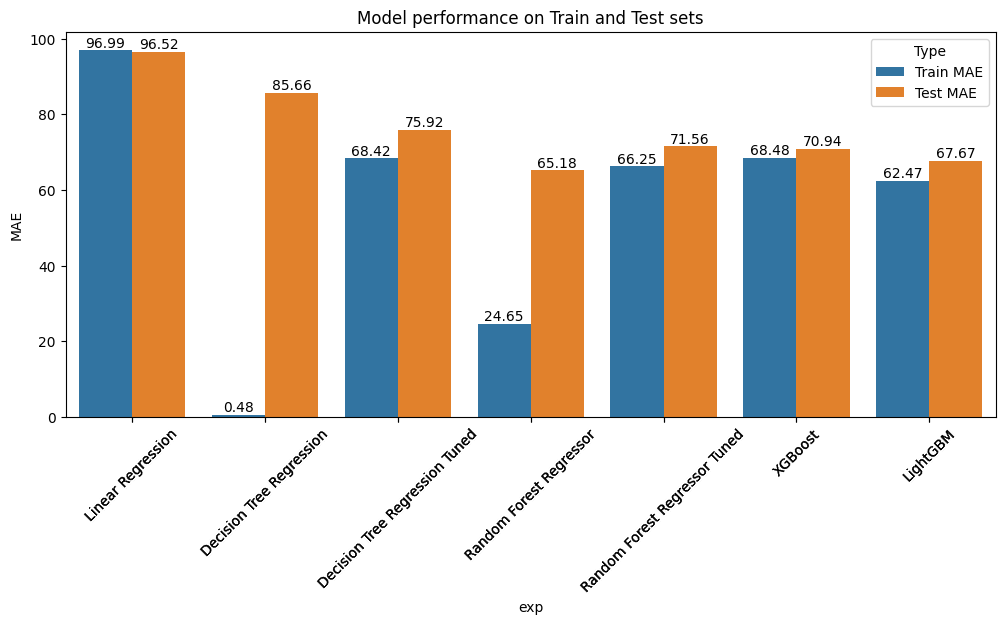

In [ ]:
melted_sidf = results_sidf[["exp", "Train MAE", "Test MAE"]].melt(id_vars=["exp"], var_name="Type", value_name="MAE")

plt.figure(figsize=(12, 5))
bar_containers = sns.barplot(x="exp", y="MAE", data=melted_sidf, hue="Type")
plt.xticks(rotation=45)


all_bars = []
for bar_container in bar_containers.containers:
    all_bars.extend(bar_container.get_children())

labels = [f"{bar.get_height():.2f}" for bar in all_bars]


for bar, label in zip(all_bars, labels):
    bar_height = bar.get_height()
    x_coord = bar.get_x() + bar.get_width() / 2
    y_coord = bar_height + bar.get_y() + 0.01  # Adjust the 0.01 value to control label position
    plt.text(x_coord, y_coord, label, ha='center', va='bottom')

plt.title("Model performance on Train and Test sets")
plt.xticks(ticks=melted_sidf["exp"], rotation=45)

plt.show()

In [ ]:
# Using Modeling and Preprocessing techniques to improve the performance of models.

# Modelling Part 2

In [ ]:
# Can model based imputation improve the price prediction?

In [ ]:
#model_cols = ["host_response_rate", "host_acceptance_rate", "latitude", "longitude", "accommodates", "beds", "number_of_reviews", "number_of_reviews_ltm",
#              "review_scores_rating", "reviews_per_month", "bathrooms", "price"]

model_midf = midf[model_cols]
model_midf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252738 entries, 0 to 252737
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   host_response_rate     252738 non-null  float64
 1   host_acceptance_rate   252738 non-null  float64
 2   latitude               252738 non-null  float64
 3   longitude              252738 non-null  float64
 4   accommodates           252738 non-null  int64  
 5   beds                   252738 non-null  float64
 6   number_of_reviews      252738 non-null  int64  
 7   number_of_reviews_ltm  252738 non-null  int64  
 8   review_scores_rating   252738 non-null  float64
 9   reviews_per_month      252738 non-null  float64
 10  bathrooms              252738 non-null  float64
 11  price                  252738 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 23.1 MB


In [ ]:
X = model_midf.drop(["price"], axis = 1)
y = model_midf["price"]

X.shape, y.shape

((252738, 11), (252738,))

In [ ]:
# Split the data into train and test sets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((227464, 11), (25274, 11), (227464,), (25274,))

In [ ]:
# Creating a basic function that can be used for training and evaluating any model (To remove redundancy).

In [ ]:
def train_and_eval(model_obj, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):

  # Train
  model = model_obj
  model.fit(X_train, y_train)

  # Predictions
  train_preds = model.predict(X_train)
  test_preds = model.predict(X_test)

  # Evaluation
  results = display_results(model, y_train, train_preds, y_test, test_preds, exp = model.__class__.__name__)

  return results

In [ ]:
# Repeat the basline modeling with model_imputed_df.

In [ ]:
lr_model = LinearRegression()
dtr_model = DecisionTreeRegressor()
dtr_model_tuned = DecisionTreeRegressor(max_depth = 15, min_samples_split = 40, min_samples_leaf = 10, min_impurity_decrease=0.0001)
rfr_model = RandomForestRegressor()
rfr_model_tuned = RandomForestRegressor(n_estimators=100, max_depth = 15, min_samples_split = 40, min_samples_leaf = 10)
xgb_model = xgb.XGBRegressor()
lgbm_model = lgbm.LGBMRegressor(num_iterations = 1000)



lr_results_midf = train_and_eval(lr_model)
dtr_results_midf = train_and_eval(dtr_model)
dtr_results_tuned_midf = train_and_eval(dtr_model_tuned)
rfr_results_midf = train_and_eval(rfr_model)
rfr_results_tuned_midf = train_and_eval(rfr_model_tuned)
xgb_results_midf = train_and_eval(xgb_model)
lgbm_results_midf = train_and_eval(lgbm_model)

Results for LinearRegression:
Experiment: LinearRegression
Mean Absolute Error for Training data: 96.2760675503104
Root Mean Squared Error for Training data: 149.30416775857995
Mean Absolute Error for Test data: 95.0641784573455
Root Mean Squared Error for Test data: 147.03150343360008
Results for DecisionTreeRegressor:
Experiment: DecisionTreeRegressor
Mean Absolute Error for Training data: 0.105511356864357
Root Mean Squared Error for Training data: 2.9711521791613857
Mean Absolute Error for Test data: 82.76592672896722
Root Mean Squared Error for Test data: 149.95816879696832
Results for DecisionTreeRegressor:
Experiment: DecisionTreeRegressor
Mean Absolute Error for Training data: 65.2951068908247
Root Mean Squared Error for Training data: 108.00553964947592
Mean Absolute Error for Test data: 73.028687745311
Root Mean Squared Error for Test data: 121.9050818558501
Results for RandomForestRegressor:
Experiment: RandomForestRegressor
Mean Absolute Error for Training data: 23.25292179

In [ ]:
results_midf = pd.DataFrame([lr_results_midf, dtr_results_tuned_midf, rfr_results_tuned_midf, xgb_results_midf, lgbm_results_midf])
results_midf

,Model,exp,Train MAE,Train RMSE,Test MAE,Test RMSE
0,LinearRegression,LinearRegression,96.276068,149.304168,95.064178,147.031503
1,DecisionTreeRegressor,DecisionTreeRegressor,65.295107,108.005540,73.028688,121.905082
2,RandomForestRegressor,RandomForestRegressor,62.720528,103.863776,67.741407,112.584924
3,XGBRegressor,XGBRegressor,65.381056,105.990314,67.635524,110.714106
4,LGBMRegressor,LGBMRegressor,59.131483,94.798337,64.129969,105.178481


In [ ]:
results_sidf2 = pd.DataFrame([lr_results, dtr_results_tuned, rfr_results_tuned, xgb_results, lgbm_results])
results_sidf2["df"] = "Simple Imputation"
results_midf["df"] = "Model Imputation"
result_cat = pd.concat([results_sidf2[["Model", "Train MAE", "Test MAE", "df"]], results_midf[["Model", "Train MAE", "Test MAE", "df"]]])

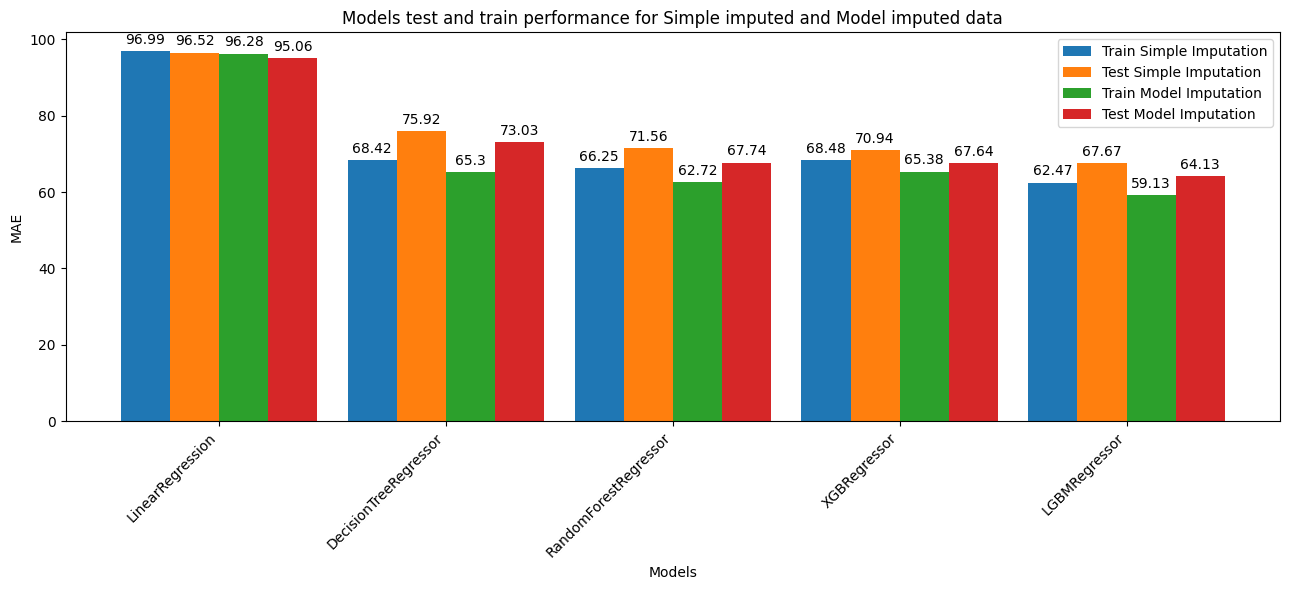

In [ ]:
df = result_cat.copy()

# Extract data from the dataframe
models = df['Model'].values
train_simple = df[df['df'] == 'Simple Imputation']['Train MAE'].values
test_simple = df[df['df'] == 'Simple Imputation']['Test MAE'].values
train_model = df[df['df'] == 'Model Imputation']['Train MAE'].values
test_model = df[df['df'] == 'Model Imputation']['Test MAE'].values

# Set up the x-axis positions for the groups
x = np.arange(len(train_simple)) * 3
width = 0.65  # Adjust the bar width as desired

# Create the figure and axis
fig, ax = plt.subplots(figsize=(13, 6))

# Plot the grouped bars
train_simple_bars = ax.bar(x - width, train_simple, width, label='Train Simple Imputation')
test_simple_bars = ax.bar(x, test_simple, width, label='Test Simple Imputation')
train_model_bars = ax.bar(x + width, train_model, width, label='Train Model Imputation')
test_model_bars = ax.bar(x + 2 * width, test_model, width, label='Test Model Imputation')

# Add x-axis labels and tick locations
ax.set_xticks(x+(width/2))
ax.set_xticklabels(models[:5], rotation=45, ha='right')

# Add legend and labels
ax.legend()
ax.set_title('Models test and train performance for Simple imputed and Model imputed data')
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
# Function to add labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels on top of each bar
add_labels(train_simple_bars)
add_labels(test_simple_bars)
add_labels(train_model_bars)
add_labels(test_model_bars)

plt.tight_layout()

# Display the plot
plt.show()

# Remove Outliers

In [ ]:
final_df = midf.copy()
final_df.head()

,Unnamed: 0,id,host_id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,City,State,bathrooms
0,0,1489424,5294164,1.0,100.0,87.0,0,1,FOURTEENTH WARD,42.66719,...,4.92,4.92,4.82,4.81,0,1,1.94,albany,ny,1.0
1,1,2992450,4621559,3.0,100.0,100.0,0,0,THIRD WARD,42.65789,...,4.22,4.56,3.22,3.67,0,1,0.08,albany,ny,1.0
2,2,3820211,19648678,1.0,100.0,66.0,0,1,SIXTH WARD,42.65222,...,4.86,4.80,4.82,4.78,0,4,2.51,albany,ny,1.0
3,3,5651579,29288920,1.0,100.0,99.0,0,1,SECOND WARD,42.64615,...,4.82,4.87,4.79,4.64,0,2,3.13,albany,ny,1.0
4,4,6623339,19648678,1.0,100.0,66.0,0,1,SIXTH WARD,42.65222,...,4.83,4.68,4.81,4.72,0,4,2.87,albany,ny,1.0


<Axes: ylabel='price'>

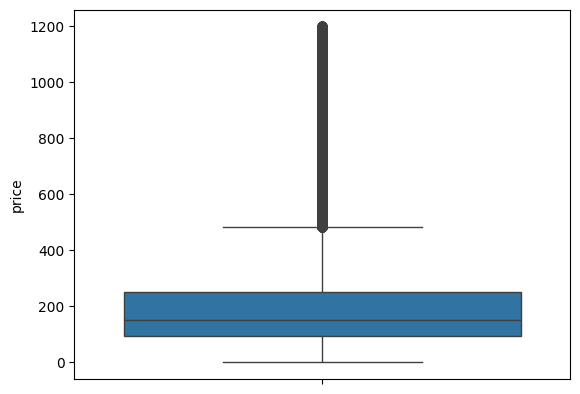

In [ ]:
sns.boxplot(final_df["price"])

In [ ]:
final_df = final_df[final_df["price"] < 450]

In [ ]:
final_df2 = final_df[model_cols]

X = final_df2.drop(["price"], axis = 1)
y = final_df2["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(206676, 11) (22964, 11) (206676,) (22964,)


In [ ]:
# Creating a function for modeling experiments.

def model_exp(X_train, y_train, X_test, y_test):

  lr_model = LinearRegression()
  dtr_model_tuned = DecisionTreeRegressor(max_depth = 15, min_samples_split = 40, min_samples_leaf = 10, min_impurity_decrease=0.0001)
  rfr_model_tuned = RandomForestRegressor(n_estimators=100, max_depth = 15, min_samples_split = 40, min_samples_leaf = 10)
  xgb_model = xgb.XGBRegressor()
  lgbm_model = lgbm.LGBMRegressor(num_iterations = 1000)



  lr_results_midf = train_and_eval(lr_model, X_train, y_train, X_test, y_test)
  dtr_results_tuned_midf = train_and_eval(dtr_model_tuned, X_train, y_train, X_test, y_test)
  rfr_results_tuned_midf = train_and_eval(rfr_model_tuned, X_train, y_train, X_test, y_test)
  xgb_results_midf = train_and_eval(xgb_model, X_train, y_train, X_test, y_test)
  lgbm_results_midf = train_and_eval(lgbm_model, X_train, y_train, X_test, y_test)

  results_midf = pd.DataFrame([lr_results_midf, dtr_results_tuned_midf, rfr_results_tuned_midf, xgb_results_midf, lgbm_results_midf])

  return results_midf

In [ ]:
results_3 = model_exp(X_train, y_train, X_test, y_test)
results_3

Results for LinearRegression:
Experiment: LinearRegression
Mean Absolute Error for Training data: 59.90980289322919
Root Mean Squared Error for Training data: 78.32824641924927
Mean Absolute Error for Test data: 60.137048327225756
Root Mean Squared Error for Test data: 78.39741270480148
Results for DecisionTreeRegressor:
Experiment: DecisionTreeRegressor
Mean Absolute Error for Training data: 40.96120919070852
Root Mean Squared Error for Training data: 56.690495169753014
Mean Absolute Error for Test data: 45.99180421079579
Root Mean Squared Error for Test data: 63.88511444919717
Results for RandomForestRegressor:
Experiment: RandomForestRegressor
Mean Absolute Error for Training data: 39.32927223380969
Root Mean Squared Error for Training data: 54.15284573175807
Mean Absolute Error for Test data: 43.0890350284823
Root Mean Squared Error for Test data: 59.33974835483844
Results for XGBRegressor:
Experiment: XGBRegressor
Mean Absolute Error for Training data: 41.04119816704399
Root Mean 

,Model,exp,Train MAE,Train RMSE,Test MAE,Test RMSE
0,LinearRegression,LinearRegression,59.909803,78.328246,60.137048,78.397413
1,DecisionTreeRegressor,DecisionTreeRegressor,40.961209,56.690495,45.991804,63.885114
2,RandomForestRegressor,RandomForestRegressor,39.329272,54.152846,43.089035,59.339748
3,XGBRegressor,XGBRegressor,41.041198,56.030926,42.833351,58.531832
4,LGBMRegressor,LGBMRegressor,37.901120,51.841255,41.155545,56.525077


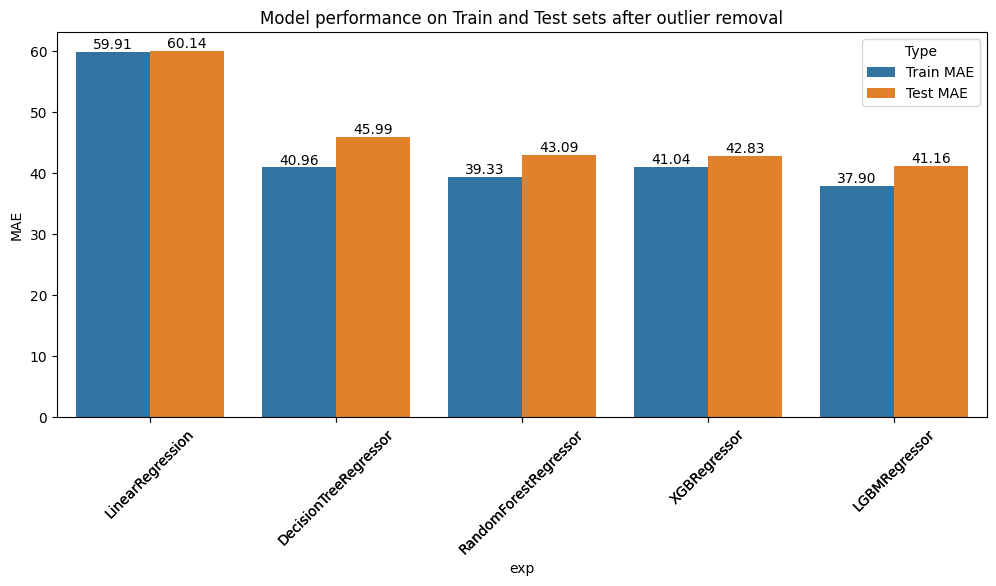

In [ ]:
melted_df = results_3[["exp", "Train MAE", "Test MAE"]].melt(id_vars=["exp"], var_name="Type", value_name="MAE")

plt.figure(figsize=(12, 5))
bar_containers = sns.barplot(x="exp", y="MAE", data=melted_df, hue="Type")
plt.xticks(rotation=45)


all_bars = []
for bar_container in bar_containers.containers:
    all_bars.extend(bar_container.get_children())

labels = [f"{bar.get_height():.2f}" for bar in all_bars]


for bar, label in zip(all_bars, labels):
    bar_height = bar.get_height()
    x_coord = bar.get_x() + bar.get_width() / 2
    y_coord = bar_height + bar.get_y() + 0.01  # Adjust the 0.01 value to control label position
    plt.text(x_coord, y_coord, label, ha='center', va='bottom')

plt.title("Model performance on Train and Test sets after outlier removal")
plt.xticks(ticks=melted_df["exp"], rotation=45)

plt.show()

# Hyperparameter Tuning using Optuna

In [46]:
def objective(trial, X_train, y_train, X_test, y_test):


    param = {
        'objective': 'mae',
        'random_state': 42,
        'booster': 'gbtree',
        'eta': trial.suggest_float('eta', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'num_parallel_tree': trial.suggest_int('num_parallel_tree', 1, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
        'gamma': trial.suggest_float('gamma', 0, 50),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'tree_method': 'gpu_hist',
        'verbosity': 0
    }

    model = LGBMRegressor(**param, num_iterations=1000)

    model.fit(X_train, y_train,eval_set=[(X_test,y_test)])

    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)

    return mae

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=50, n_jobs = -1, show_progress_bar=True)
print('Number of finished trials:', len(study.trials))
print('Best trial:\n', study.best_trial.params)

[I 2024-04-27 18:59:30,411] A new study created in memory with name: no-name-29568e35-1daf-45d1-83da-c7bb20af22d4


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-04-27 18:59:48,077] Trial 1 finished with value: 42.61769461501978 and parameters: {'eta': 0.01754298261422263, 'subsample': 0.4231320207563274, 'colsample_bytree': 0.3092685865590596, 'num_parallel_tree': 19, 'min_child_weight': 21, 'gamma': 0.18147372607616452, 'max_depth': 5, 'learning_rate': 0.07620572902921093}. Best is trial 1 with value: 42.61769461501978.
[I 2024-04-27 18:59:49,504] Trial 0 finished with value: 40.465042955737175 and parameters: {'eta': 0.0699165922647752, 'subsample': 0.5026823381075294, 'colsample_bytree': 0.8906419717663063, 'num_parallel_tree': 10, 'min_child_weight': 62, 'gamma': 48.69915207776463, 'max_depth': 9, 'learning_rate': 0.14072220473529046}. Best is trial 0 with value: 40.465042955737175.
[I 2024-04-27 19:00:02,412] Trial 2 finished with value: 46.33053524462168 and parameters: {'eta': 0.08390175941009924, 'subsample': 0.6466348358078232, 'colsample_bytree': 0.9309397440879621, 'num_parallel_tree': 13, 'min_child_weight': 76, 'gamma': 26

In [47]:
params = study.best_trial.params

In [48]:
lgbm_hpo = LGBMRegressor(**params, num_iterations = 1000, verbose = -1)
lgbm_results_hpo = train_and_eval(lgbm_hpo, X_train, y_train, X_test, y_test)

Results for LGBMRegressor:
Experiment: LGBMRegressor
Mean Absolute Error for Training data: 36.23823336040492
Root Mean Squared Error for Training data: 50.01387050594748
Mean Absolute Error for Test data: 40.425172647200334
Root Mean Squared Error for Test data: 55.91628032377962


In [ ]:
# K-Fold cross validation

In [ ]:
from sklearn.model_selection import KFold

scores = []
kf = KFold(n_splits=5, random_state=42, shuffle=True)

X_kf = final_df2.drop("price", axis = 1)
y_kf = final_df2["price"]

for i, (train_index, test_index) in enumerate(kf.split(X_kf)):

    X_tr, y_tr, X_val, y_val = X_kf.iloc[train_index], y_kf.iloc[train_index], X_kf.iloc[test_index], y_kf.iloc[test_index]

    model = LGBMRegressor(**params, num_iterations = 1000, verbose = -1)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)])

    preds = model.predict(X_val)
    score = mean_absolute_error(y_val, preds)
    scores.append(score)

    print(f"Fold{i} Val MAE: {score}")


print(f"5 Fold Average Val MAE: {np.mean(scores)}")

In [51]:
final_df.columns

Index(['Unnamed: 0', 'id', 'host_id', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_identity_verified', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'room_type', 'accommodates', 'beds', 'amenities', 'price',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count', 'reviews_per_month', 'City', 'State',
       'bathrooms'],
      dtype='object')

In [ ]:
final_df.shape

# Final Model

In [ ]:
# City, State are added now to make the experiments faster and get to a good model. Now adding these columns for a final prediction.

new_cols = model_cols
new_cols.extend(["City", "State", "host_response_time"])
new_cols

In [54]:
all_df = final_df[new_cols]
all_df = pd.get_dummies(all_df, columns = ["host_response_time", "City", "State"], drop_first=True)


X = all_df.drop("price", axis = 1)
y = all_df["price"]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(206676, 66) (22964, 66) (206676,) (22964,)


In [56]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [57]:
lgbm_model = LGBMRegressor(**params, num_iterations = 1000, verbose = -1)

lgbm_final_result = train_and_eval(lgbm_model, X_train, y_train, X_test, y_test)

Results for LGBMRegressor:
Experiment: LGBMRegressor
Mean Absolute Error for Training data: 36.12806593803845
Root Mean Squared Error for Training data: 49.7791477067977
Mean Absolute Error for Test data: 40.40042223129135
Root Mean Squared Error for Test data: 55.805408025937176
